## Dependencies

In [4]:
from utils import plot_label_freq, Classifier, LSTMBackbone, SpectrogramDataset, CLASS_MAPPING, get_device, train, torch_train_val_split, set_seed, test_model, plot_train_val_losses, get_classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import numpy as np

DATA_PATH = "/home/alex/Downloads/archive(1)/data/"
EPOCHS = 2
LR = 1e-4
BATCH_SIZE = 32
RANDOM_SEED = 42
RNN_HIDDEN_SIZE = 64
NUM_CATEGORIES = 10
DEVICE = get_device()

print(f"Using {DEVICE}")

Using cuda


## Step 4

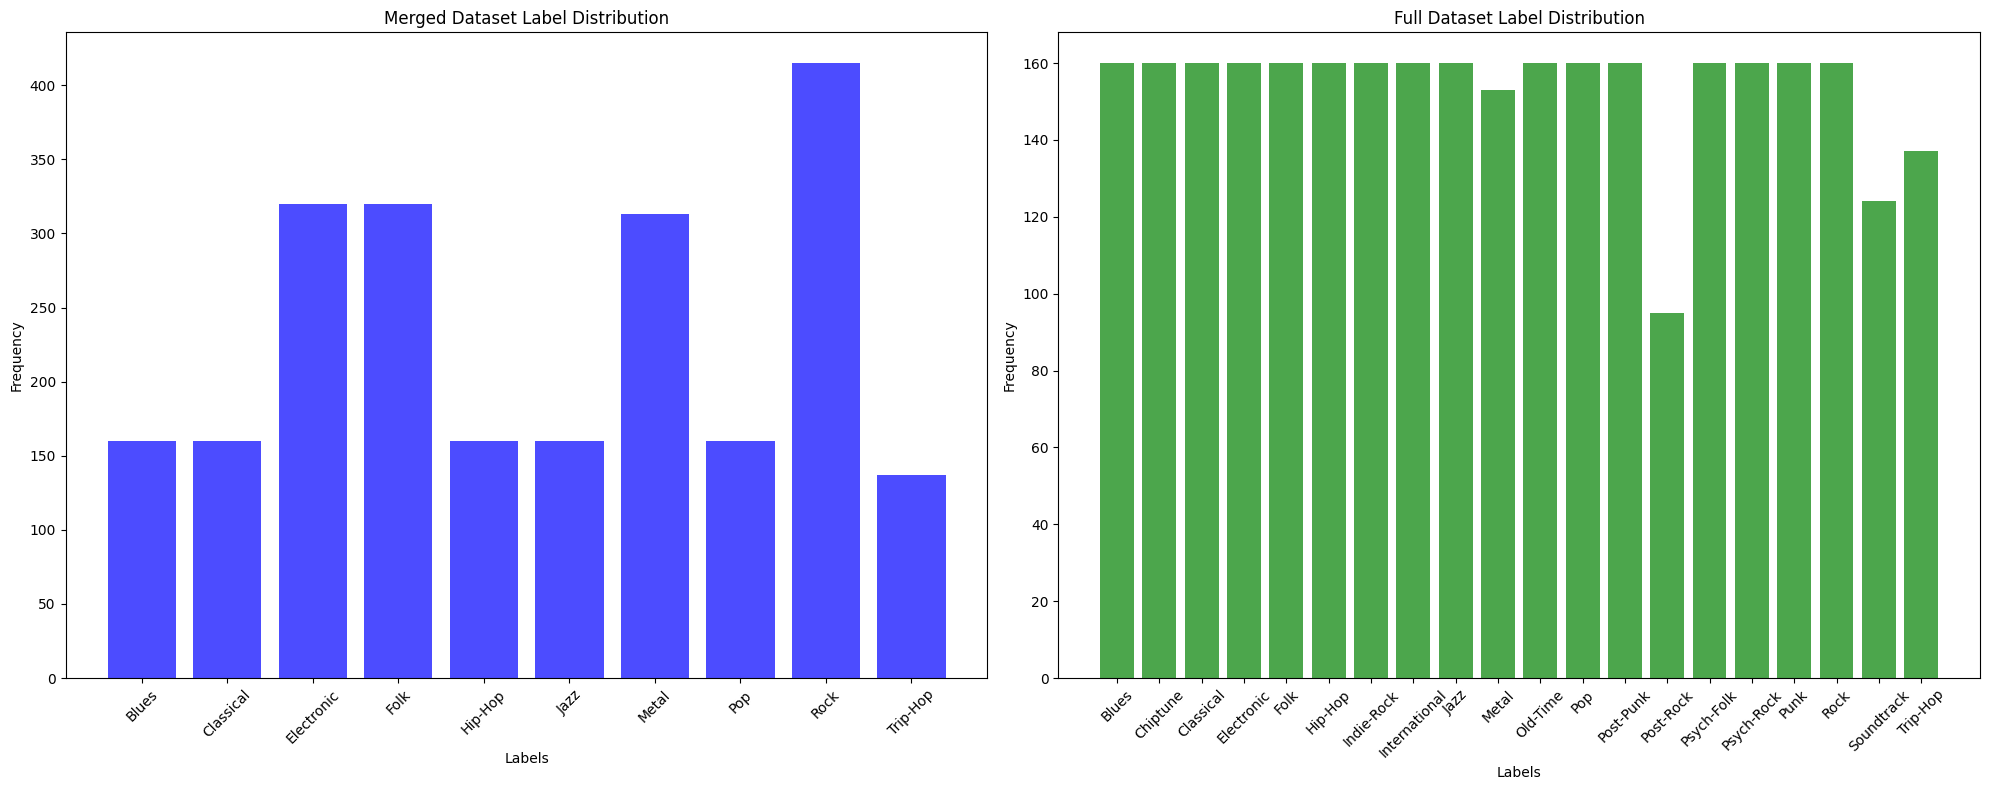

In [2]:
# get each datasets data
full_dataset = SpectrogramDataset(DATA_PATH + "fma_genre_spectrograms/", class_mapping=None, train=True)
mel_specs_data = SpectrogramDataset(DATA_PATH + "fma_genre_spectrograms/", class_mapping=CLASS_MAPPING, train=True)

plot_label_freq(mel_specs_data, full_dataset, save_title="spectogram_genre_labels.png")

del full_dataset, mel_specs_data

## Steps 5 and 6

### Prepare Data

In [2]:
# test
mel_specs_test_data = SpectrogramDataset(DATA_PATH + "fma_genre_spectrograms/", class_mapping=CLASS_MAPPING, train=False)

beat_mel_specs_test_data = SpectrogramDataset(DATA_PATH + "fma_genre_spectrograms_beat/", class_mapping=CLASS_MAPPING, train=False)

chroma_test_data = SpectrogramDataset(DATA_PATH + 'fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, 
                                    train=False, feat_type='chroma', max_length=-1)
fused_test_data = SpectrogramDataset(DATA_PATH + 'fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, 
                                    train=True, feat_type='fused', max_length=-1)
# train
mel_specs_data = SpectrogramDataset(DATA_PATH + "fma_genre_spectrograms/", class_mapping=CLASS_MAPPING, train=True)

beat_mel_specs_data = SpectrogramDataset(DATA_PATH + 'fma_genre_spectrograms_beat/', class_mapping=CLASS_MAPPING, 
                                            train=True, feat_type='mel', max_length=-1)

chroma_data = SpectrogramDataset(DATA_PATH + 'fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, 
                                        train=True, feat_type='chroma', max_length=-1)
                                        
fused_data = SpectrogramDataset(DATA_PATH + 'fma_genre_spectrograms/', class_mapping=CLASS_MAPPING, 
                                    train=True, feat_type='fused', max_length=-1)

### Create DataLoaders

In [16]:
# train / val
mel_specs_train_dl, mel_specs_val_dl = torch_train_val_split(dataset=mel_specs_data, batch_eval=32, batch_train=32, val_size=.2, shuffle=True)
beat_mel_specs_train_dl, beat_mel_specs_val_dl = torch_train_val_split(dataset=beat_mel_specs_data, batch_eval=32, batch_train=32, val_size=.2, shuffle=True)
chroma_train_dl, chroma_val_dl = torch_train_val_split(dataset=chroma_data, batch_eval=32, batch_train=32, val_size=.2, shuffle=True)
fused_train_dl, fused_val_dl = torch_train_val_split(dataset=fused_data, batch_eval=32, batch_train=32, val_size=.2, shuffle=True)
# test
mel_specs_test_dl, _ = torch_train_val_split(dataset=mel_specs_test_data, batch_eval=32, batch_train=32, val_size=.0, shuffle=False)
beat_mel_specs_test_dl, _ = torch_train_val_split(dataset=beat_mel_specs_test_data, batch_eval=32, batch_train=32, val_size=.0, shuffle=False)
chroma_test_dl, _ = torch_train_val_split(dataset=chroma_test_data, batch_eval=32, batch_train=32, val_size=.0, shuffle=False)
fused_test_dl, _ = torch_train_val_split(dataset=fused_test_data, batch_eval=32, batch_train=32, val_size=.0, shuffle=False)

### Overfit LSTM on one batch to make sure everything works

In [3]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(mel_specs_data.feat_dim, rnn_size=64, num_layers=2, bidirectional=False)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

_, _ = train(model, mel_specs_train_dl, None, optimizer, EPOCHS, device=DEVICE, overfit_batch=True)

Training in overfitting mode...
Epoch 1, Loss at training set: 2.345689535140991
Epoch 20, Loss at training set: 2.2652673721313477
Epoch 40, Loss at training set: 2.199892282485962
Epoch 60, Loss at training set: 2.14975905418396
Epoch 80, Loss at training set: 2.0610642433166504
Epoch 100, Loss at training set: 2.01857328414917
Epoch 120, Loss at training set: 1.9126741886138916
Epoch 140, Loss at training set: 1.7898070812225342
Epoch 160, Loss at training set: 1.6946420669555664
Epoch 180, Loss at training set: 1.5194591283798218
Epoch 200, Loss at training set: 1.4087131023406982
Epoch 220, Loss at training set: 1.4737125635147095
Epoch 240, Loss at training set: 1.226432204246521
Epoch 260, Loss at training set: 1.1223393678665161
Epoch 280, Loss at training set: 1.0201668739318848
Epoch 300, Loss at training set: 0.9472234845161438
Epoch 320, Loss at training set: 0.8905002474784851
Epoch 340, Loss at training set: 0.9835278987884521
Epoch 360, Loss at training set: 0.9284422993

### Train LSTM + Classifier on Spectograms

Training started for model model_weights/lstm_genre_mel...
Epoch 1/2
	Average Training Loss: 2.2509042970065414
	Average Validation Loss: 2.2163378397623696
Epoch 2/2
	Average Training Loss: 2.2075757158213647
	Average Validation Loss: 2.182687203089396


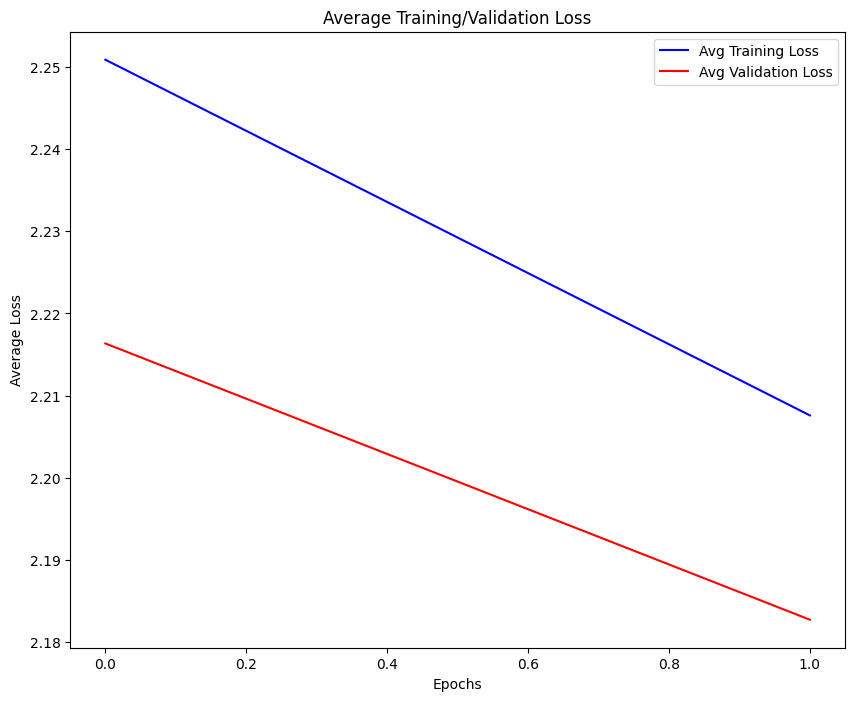

In [6]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(mel_specs_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=2, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

mel_train_losses, mel_val_losses = train(model, mel_specs_train_dl, mel_specs_val_dl, optimizer, 
                                 epochs=EPOCHS, save_path='model_weights/lstm_genre_mel.pth', device=DEVICE, overfit_batch=False)

plot_train_val_losses(mel_train_losses, mel_val_losses, save_title="assets/mel_clf_train_val_losses.png")

mel_y_true, mel_y_pred = test_model(model, mel_specs_test_dl, DEVICE)

In [7]:
del mel_specs_train_dl, mel_specs_val_dl
get_classification_report(y_pred=np.hstack(mel_y_pred), y_true=np.hstack(mel_y_true))

              precision    recall  f1-score   support

           0        nan      0.00      0.00        40
           1        nan      0.00      0.00        40
           2       0.00      0.00      0.00        80
           3        nan      0.00      0.00        80
           4        nan      0.00      0.00        40
           5        nan      0.00      0.00        40
           6        nan      0.00      0.00        78
           7        nan      0.00      0.00        40
           8       0.18      1.00      0.30       103
           9        nan      0.00      0.00        34

    accuracy                           0.18       575
   macro avg       0.09      0.10      0.03       575
weighted avg       0.10      0.18      0.05       575



### Train LSTM + Classifier on Beat Synced Spectograms

Training started for model model_weights/lstm_genre_beat_mel...
Epoch 1/2
	Average Training Loss: 2.245510993332698
	Average Validation Loss: 2.2058129628499348
Epoch 2/2
	Average Training Loss: 2.192806182236507
	Average Validation Loss: 2.160524845123291


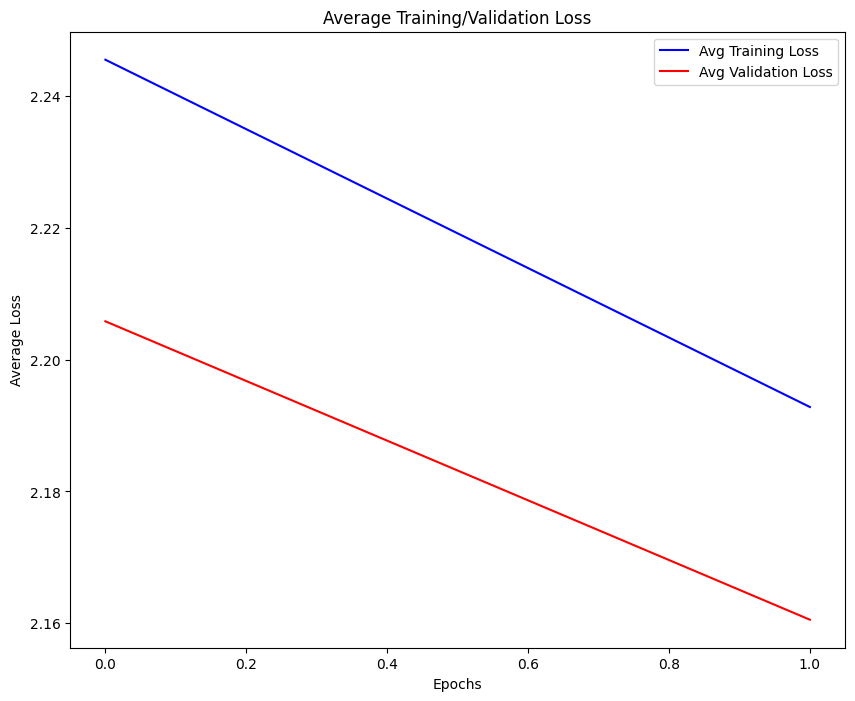

In [8]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(beat_mel_specs_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=2, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

beat_mel_train_losses, beat_mel_val_losses = train(model, beat_mel_specs_train_dl, beat_mel_specs_val_dl, optimizer, 
                                 epochs=EPOCHS, save_path='model_weights/lstm_genre_beat_mel.pth', device=DEVICE, overfit_batch=False)

plot_train_val_losses(beat_mel_train_losses, beat_mel_val_losses, save_title="assets/beat_mel_clf_train_val_losses.png")

beat_mel_y_true, beat_mel_y_pred = test_model(model, beat_mel_specs_test_dl, DEVICE)

In [13]:
del beat_mel_specs_train_dl, beat_mel_specs_val_dl
get_classification_report(y_pred=np.hstack(beat_mel_y_pred), y_true=np.hstack(beat_mel_y_true))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.44      0.10      0.16        80
           3       0.50      0.01      0.02        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00        40
           8       0.19      1.00      0.31       103
           9       0.00      0.00      0.00        34

    accuracy                           0.19       575
   macro avg       0.11      0.11      0.05       575
weighted avg       0.16      0.19      0.08       575



/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

### Train LSTM + Classifier on Chromagrams

Training started for model model_weights/lstm_genre_chroma...
Epoch 1/2
	Average Training Loss: 2.2904966494132735
	Average Validation Loss: 2.276112190882365
Epoch 2/2
	Average Training Loss: 2.2559322365399064
	Average Validation Loss: 2.229147370656331


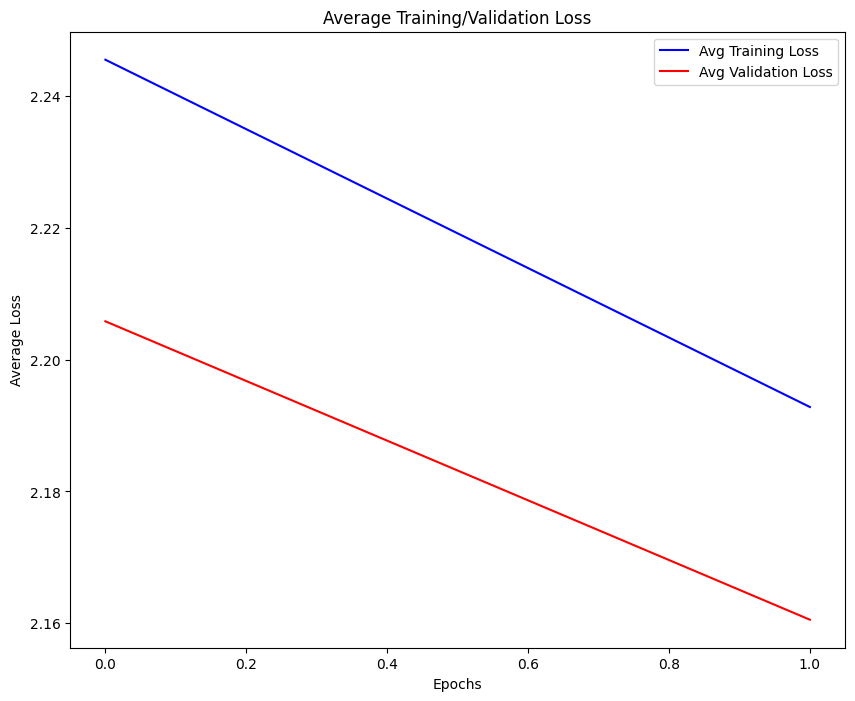

In [15]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(chroma_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=2, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

chroma_train_losses, chroma_val_losses = train(model, chroma_train_dl, chroma_val_dl, optimizer, 
                                 epochs=EPOCHS, save_path='model_weights/lstm_genre_chroma.pth', device=DEVICE, overfit_batch=False)

plot_train_val_losses(beat_mel_train_losses, beat_mel_val_losses, save_title="assets/chroma_clf_train_val_losses.png")

chroma_y_true, chroma_y_pred = test_model(model, chroma_test_dl, DEVICE)

In [33]:
del chroma_train_dl, chroma_val_dl
get_classification_report(y_pred=np.hstack(chroma_y_pred), y_true=np.hstack(chroma_y_true))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        80
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00        40
           8       0.18      1.00      0.30       103
           9       0.00      0.00      0.00        34

    accuracy                           0.18       575
   macro avg       0.02      0.10      0.03       575
weighted avg       0.03      0.18      0.05       575



/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

### Train LSTM + Classifier on Spectograms + Chromagrams (Fused)

Training started for model model_weights/lstm_genre_fused...
Epoch 1/2
	Average Training Loss: 2.2492615107832283
	Average Validation Loss: 2.214188289642334
Epoch 2/2
	Average Training Loss: 2.195182989383566
	Average Validation Loss: 2.161529843012492


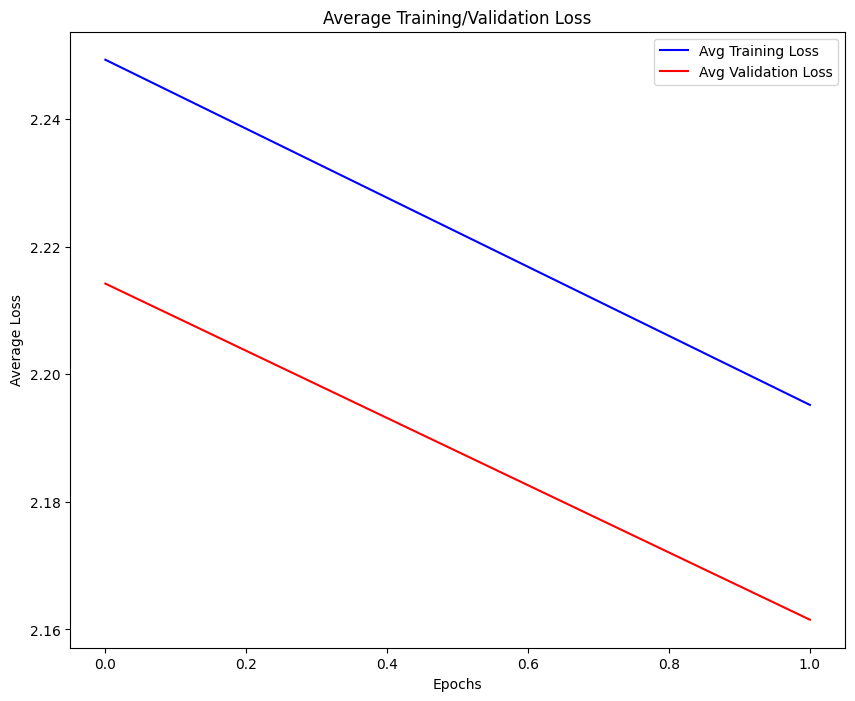

In [19]:
set_seed(RANDOM_SEED)
backbone = LSTMBackbone(fused_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=2, bidirectional=True)
set_seed(RANDOM_SEED)
model = Classifier(NUM_CATEGORIES, backbone)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

fused_train_losses, fused_val_losses = train(model, fused_train_dl, fused_val_dl, optimizer, 
                                 epochs=EPOCHS, save_path='model_weights/lstm_genre_fused.pth', device=DEVICE, overfit_batch=False)

plot_train_val_losses(fused_train_losses, fused_val_losses, save_title="assets/fused_clf_train_val_losses.png")

fused_y_true, fused_y_pred = test_model(model, fused_test_dl, DEVICE)

In [32]:
del fused_train_dl, fused_val_dl
get_classification_report(y_pred=np.hstack(fused_y_pred), y_true=np.hstack(fused_y_true))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       160
           1       0.00      0.00      0.00       160
           2       0.34      0.23      0.27       320
           3       0.00      0.00      0.00       320
           4       0.00      0.00      0.00       160
           5       0.00      0.00      0.00       160
           6       0.00      0.00      0.00       313
           7       0.00      0.00      0.00       160
           8       0.19      0.98      0.32       415
           9       0.00      0.00      0.00       137

    accuracy                           0.21      2305
   macro avg       0.05      0.12      0.06      2305
weighted avg       0.08      0.21      0.10      2305



/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/miniconda3/envs/pattrec1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz